In [1]:
import os
import re
import csv
import random
import sqlite3
import warnings
import operator
import numpy as np


from scipy import spatial
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from nltk.corpus import stopwords

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [2]:
# paper here    https://www.rug.nl/research/portal/files/74389682/paper40.pdf
# download here https://drive.google.com/drive/folders/133EPm4mO9dN6A0Cw6A6Sx1ABa-25BI8e
embedding_ita1_file = './embeddings/model_hate_300.bin' 
# paper here    http://ceur-ws.org/Vol-2263/paper013.pdf
# download here http://www.italianlp.it/resources/italian-word-embeddings/
embedding_ita2_file = './embeddings/itwac128.sqlite' 
# paper here    http://ceur-ws.org/Vol-1404/paper_11.pdf
# download here http://hlt.isti.cnr.it/wordembeddings/
embedding_ita3_file = './embeddings/wiki_w2v/wiki_iter=5_algorithm=skipgram_window=10_size=300_neg-samples=10.m'
# paper here    https://arxiv.org/pdf/1301.3781.pdf
# download here https://code.google.com/archive/p/word2vec/
embedding_eng1_file = './embeddings/GoogleNews-vectors-negative300.bin.gz'
# paper here    https://nlp.stanford.edu/pubs/glove.pdf
# download here https://nlp.stanford.edu/projects/glove/
embedding_eng2_file = './embeddings/glove.6B.300d.txt'

bias_samples_ita = './support_files/bias_ita_libs/'
bias_samples_eng = './support_files/bias_eng_libs/'

## Functions to get files and embeddings

In [3]:
def get_embedding(embedding_file): 
    embeds = KeyedVectors.load(embedding_file).wv
    return embeds

def get_embedding2(embedding_file): 
    return Word2Vec.load(embedding_file).wv

def load_wordvec_model(modelFile, flagBin):
    model = KeyedVectors.load_word2vec_format(os.path.join(modelFile), binary=flagBin).wv
    return model

def get_embedding_sqlite(input_file):
    embedding = dict()
    #outfile = codecs.open(sys.argv[2], 'w', 'utf-8')
    with  sqlite3.connect(input_file) as conn:
        c = conn.cursor()
        for row in c.execute("SELECT * from store"):
            if row[0] == "\\t":
                continue
            embedding[row[0]] = row[1:-1]
    return embedding

def load_glove_embeddings(filename):
    with open(embedding_eng2_file, 'r') as f_embed:
        vocab = [line.split()[0] for line in f_embed]
    with open(embedding_eng2_file, 'r') as f_embed:
        vec = [ [float(elem) for elem in line.split()[1:]] for line in f_embed]
    embedding = {w: v for w, v in zip(vocab, vec)}
    return embedding


def load_bias_csv_file(bias_samples_dir, file_info):
    filename = os.path.join(bias_samples_dir, '{}.txt'.format(file_info))
    data = {}
    return data
    
def load_bias_txt_file(bias_samples_dir, file_info):
    filename = os.path.join(bias_samples_dir, '{}.txt'.format(file_info))
    data = []
    with open(filename) as f:
        for l in f:
            data.append(l.strip())
    return data    
        
def acceptable_word(word, lang='english'):
    if word in stopwords.words(lang): 
        return False
    if word.lower() != word:
        return False
    if len(word) >= 20:
        return False
    if bool(re.search(r'\d', word)):
        return False
    if bool(re.search(r"[^A-Za-z,!?èéàòùì\'\`]", word)):
        return False
    return True

def get_list_words(embed): 
    return [word for word in embed.vocab if acceptable_word(word)]

In [4]:
male_eng_specific = load_bias_txt_file(bias_samples_eng, 'male_word_file')
female_eng_specific = load_bias_txt_file(bias_samples_eng, 'female_word_file')
exclude_eng_words = male_eng_specific + female_eng_specific

eng_professions = load_bias_txt_file(bias_samples_eng, 'occupations') 

In [5]:
male_ita_specific = load_bias_txt_file(bias_samples_ita, 'male_word_file')
female_ita_specific = load_bias_txt_file(bias_samples_ita, 'female_word_file')
exclude_ita_words = male_ita_specific + female_ita_specific

## Functions to compute gender bias 

In [6]:
def cosine_similarity(word1, word2, embedding):
    vecs = []
    for term in [word1, word2]:
        try:
            vecs.append(embedding[term])
        except:
            print(term)
            return 0 
    result = 1 - spatial.distance.cosine(vecs[0], vecs[1])
    if result is 'nan':
        result = 0
    return result


def compute_bias_by_projection(embedding, limit_voc, male_word, female_word):    
    m_bias_proj = [cosine_similarity(word, male_word, embedding) for word in limit_voc]
    f_bias_proj = [cosine_similarity(word, female_word, embedding) for word in limit_voc]
    d = {}
    for w, m, f in zip(limit_voc, m_bias_proj, f_bias_proj):
        d[w] = m - f
    return d

In [7]:
def report_bias(gender_bias, male_word, female_word, size = 500):
    bias = 0.0
    for k in gender_bias:
        bias += np.abs(gender_bias[k])
    print('\nOverall gender bias score for {}-{}: {}'.format(
        male_word, female_word, bias/len(gender_bias)))
    
    sorted_g = sorted(gender_bias.items(), key=operator.itemgetter(1))
    
    extreme_male_words = [item for item in sorted_g[-size:]]
    print('\nTop 5 words related to {}\n rank |  word   score'.format(male_word))
    for i in range(1,6): 
        print('  {0}.  | {1}   {2:.3f}'.format(i, extreme_male_words[-i][0], extreme_male_words[-i][1]))

    extreme_female_words = [item for item in sorted_g[:size]]
    print('\nTop 5 words related to {}\n rank |  word   score'.format(female_word))
    for i in range(5): 
        print('  {0}.  | {1}   {2:.3f}'.format(i+1, extreme_female_words[i][0], extreme_female_words[i][1]))

    return extreme_male_words, extreme_female_words


def cluster_and_visualize(male_words, female_words, embedding,  male_word, female_word, random_state=1):
   
    # Try to cluster female and male words with KMeans
    X = [embedding[w] for w in male_words + female_words]
    Y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(X)
    Y_true = [1]*len(male_words) + [0]*len(male_words)
    correct = [1 if item1 == item2 else 0 for (item1, item2) in zip(Y_true, Y_pred) ]
    print('\nGender cluster precision: {}'.format(sum(correct)/float(len(correct))))
    
    # plot in 2D using t-Distributed Stochastic Neighbor Embedding (t-SNE)
    X_2D = TSNE(n_components=2, random_state=random_state).fit_transform(X)
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 9))
    for x,l in zip(X_2D, Y_pred):
        if l:
            ax.scatter(x[0], x[1], marker = '.', c = 'c')
        else:
            ax.scatter(x[0], x[1], marker = '.', c = 'r')
    
    title = '{} - {}'.format(male_word, female_word)
    ax.text(.5, .9, title ,transform=ax.transAxes, fontsize=18)
    fig.show()
    fig.savefig('images/cluster2D_{}-{}.png'.format(male_word, female_word), bbox_inches='tight')

## Function to compute gender neigbours bias 

In [8]:
def get_gender_neigbours_bias(word, embedding, gender_bias, limit_vocab, k=100):
    
    sim_all = [[cosine_similarity(word, emb_word, embedding), emb_word] for emb_word in limit_vocab]
    
    m = 0
    f = 0
    for neig_word in sorted(sim_all, key=lambda x: x[0], reverse=True)[:k+1]:
        if neig_word[1] == word: 
            continue
        if gender_bias[neig_word[1]] > 0:
            m += 1
        else: 
            f += 1
    return m, f


def gender_neighbours_list_words(list_words, embedding, gender_bias, limit_vocab, k_neigh=100):
    result_list = []
    for word in list_words:
        m, f = get_gender_neigbours_bias(word, embedding, gender_bias, limit_vocab, k_neigh)
        # word, gender direction, ratio m/f over neighbours
        result_list.append((word, gender_bias[word], m/(f+m)))
    
    return result_list

def write_result(directory, filename, result_list): 
    with open(os.path.join(directory, filename), 'w')  as f: 
        f.write('job,neighbours_bias\n')
        for line in result_list:
            f.write(line[0] + ',' + str(line[1]) + '\n') 

def plot_correlation(result_list, labels_list, skip=3):
    X = [t[1] for t in result_list]
    Y = [t[2] for t in result_list]

    fig, axs = plt.subplots(1, 1, figsize=(15, 9))
    axs.scatter(X,Y, color = 'c', s=12)

    for t in result_list:
        if t[0] in labels_list[::skip]:
            axs.annotate(t[0], xy=(t[1], t[2]), xytext=(t[1], t[2]), textcoords="data", fontsize=12)
    
    axs.set_ylim(0,1)
#    axs.text(.03, .85, 'Correlation gender direction bias and gender ratio in neighbours', 
#                transform=axs.transAxes, fontsize=20)
    fig.show()

## Functions to compute gender bias in Italian

In [9]:
list_gender_changes = [
    {'tore_': 'trice_', 'trice_': 'tore_'}, # attore - attrice 
    {'tori_': 'trici_', 'trici_': 'tori_'}, # attori - attrici 
    {'o_':'a_', 'a_':'o_'},                 # bello - bella
    {'i_':'e_', 'e_':'i_'},                 # piccoli - piccole 
    {'e_': 'essa_', 'essa_': 'e_'},         # sacerdote - sacerdotessa
    {'i_': 'esse_', 'esse_': 'i_'}          # sacerdoti - sacerdotesse
]

def store_male_female_pair_in_dict(word1, word2, endings, word_pair): 
    male_endings = endings[0]
    female_endings = endings[1]
    if male_endings == word1[-len(male_endings):]:
        key = word1 + '_or_' + word2
        word_pair[key] = [word1, word2]
    else: 
        key = word2 + '_or_' +  word1
        word_pair[key] = [word2, word1]
    return word_pair


def get_gender_words(list_vocab): 
    word_pair = {}
    word_gender = set()
    
    for word in list_vocab: 
        for gender_change in list_gender_changes: 
            regex_gender = '|'.join(gender_change)
            new_word1 = re.sub(regex_gender, lambda m: gender_change[m.group()], word + '_')
            
            new_word = new_word1[:-1]
            if new_word != word and new_word in list_vocab:
                endings = [letters.replace('_', '') for letters in gender_change]
                word_pair = store_male_female_pair_in_dict(word, new_word, endings, word_pair) 
                word_gender.update([new_word, word])
                break

    word_neutral = set(list_vocab) - word_gender
    return word_neutral, word_pair

In [10]:
def compute_bias_ita_by_projection(embedding, word_neutral, word_pair, male_word, female_word):

    # same as in English
    m_bias_proj = [cosine_similarity(word, male_word, embedding) for word in word_neutral]
    f_bias_proj = [cosine_similarity(word, female_word, embedding) for word in word_neutral]
    
    # for conjugated word use male version for m_bias and 
    for _, g_word in word_pair.items(): 
        m_bias_proj.append(cosine_similarity(g_word[0], male_word, embedding))
        f_bias_proj.append(cosine_similarity(g_word[1], male_word, embedding))
    
    d = {}
    limit_voc = list(word_neutral) + [root for root in word_pair]
    for w, m, f in zip(limit_voc, m_bias_proj, f_bias_proj):
        d[w] = m - f
    return d

def cluster_and_visualize_ita(male_words, female_words, embedding,  male_word, female_word, random_state=1):
   
    # Try to cluster female and male words with KMeans
    X = [embedding[w] for w in male_words + female_words]
    Y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(X)
    Y_true = [1]*len(male_words) + [0]*len(male_words)
    correct = [1 if item1 == item2 else 0 for (item1, item2) in zip(Y_true, Y_pred) ]
    print('\nGender cluster precision: {}'.format(sum(correct)/float(len(correct))))
    
    # plot in 2D using t-Distributed Stochastic Neighbor Embedding (t-SNE)
    X_2D = TSNE(n_components=2, random_state=random_state).fit_transform(X)
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 9))
    for x,l in zip(X_2D, Y_pred):
        if l:
            ax.scatter(x[0], x[1], marker = '.', c = 'c')
        else:
            ax.scatter(x[0], x[1], marker = '.', c = 'r')
    
    title = '{} - {}'.format(male_word, female_word)
    ax.text(.5, .9, title ,transform=ax.transAxes, fontsize=18)
    fig.show()
    fig.savefig('cluster2D_{}-{}.png'.format(male_word, female_word), bbox_inches='tight')


# English word2vec Google News - Compute bias-by-projection

In [11]:
model_w2v_AP = load_wordvec_model(embedding_eng1_file, True)
vocab = get_list_words(model_w2v_AP)

In [12]:
limit_vocab = list(set(vocab) - set(exclude_eng_words))
print('Words accepted in embedding: {}'.format(len(vocab)))
print('Words once removed gender oriented terms: {}'.format(len(limit_vocab)))

Words accepted in embedding: {} 155977
Words once removed gender oriented terms: {} 155606



Overall gender bias score for he-she: 0.050133010744301716

Top 5 words related to he
 rank |  word   score
  1.  | he'sa   0.285
  2.  | himslef   0.272
  3.  | journeyman   0.271
  4.  | andhe   0.251
  5.  | tinkerman   0.251

Top 5 words related to she
 rank |  word   score
  1.  | pagaent   -0.377
  2.  | frontwoman   -0.341
  3.  | momager   -0.339
  4.  | pregancy   -0.336
  5.  | covergirl   -0.328

Gender cluster precision: 0.007


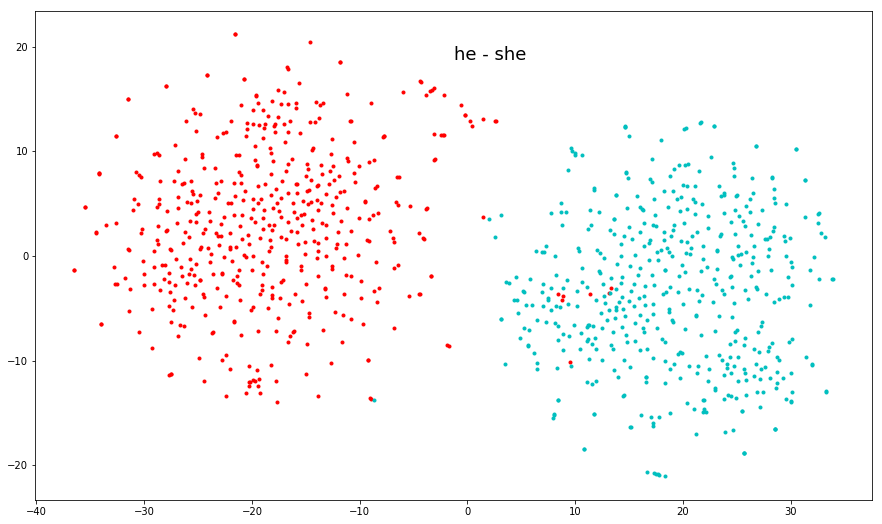

In [13]:
# compute Gender direction for each neutral words 
gender_bias_words = compute_bias_by_projection(model_w2v_AP, limit_vocab, 'he', 'she')

# report overall gender bias score based on compute Gender direction for each neutral words 
m_words, f_words = report_bias(gender_bias_words, 'he', 'she')

# cluster female and male most oriented words and 2D representation
cluster_and_visualize([word[0] for word in m_words], [word[0] for word in f_words], model_w2v_AP, 'he', 'she')

## Gender Neighbours bias words and professions

In [14]:
# Student case 
m, f = get_gender_neigbours_bias('student', model_w2v_AP, gender_bias_words, limit_vocab)
print('Student gender neighbours bias (m/tot) vs word bias: {} vs {}'.format(m/(f+m), gender_bias_words['student']))

Student gender neighbours bias (m/tot) vs word bias: 0.1 vs -0.12396527826786041


In [15]:
list_prof = [prof for prof in eng_professions if prof in limit_vocab]
list_prof = list(set(list_prof) - set(exclude_eng_words))
result_list = gender_neighbours_list_words(list_prof, model_w2v_AP, gender_bias_words, limit_vocab)
write_result(bias_samples_eng, 'occupations_bias_w2v.txt', result_list)

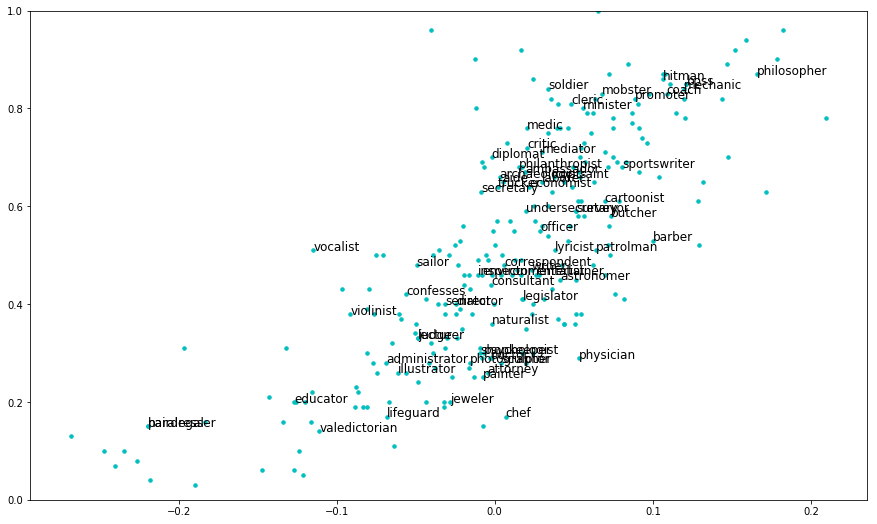

In [46]:
plot_correlation(result_list, list_prof, skip=4)

## Other pairs gender words


Overall gender bias score for him-her: 0.05379815722880893

Top 5 words related to him
 rank |  word   score
  1.  | he'sa   0.323
  2.  | us   0.319
  3.  | himslef   0.317
  4.  | verballing   0.315
  5.  | probowl   0.308

Top 5 words related to her
 rank |  word   score
  1.  | momager   -0.338
  2.  | pagaent   -0.334
  3.  | beautician   -0.326
  4.  | frontwoman   -0.325
  5.  | alumna   -0.325

Gender cluster precision: 0.002


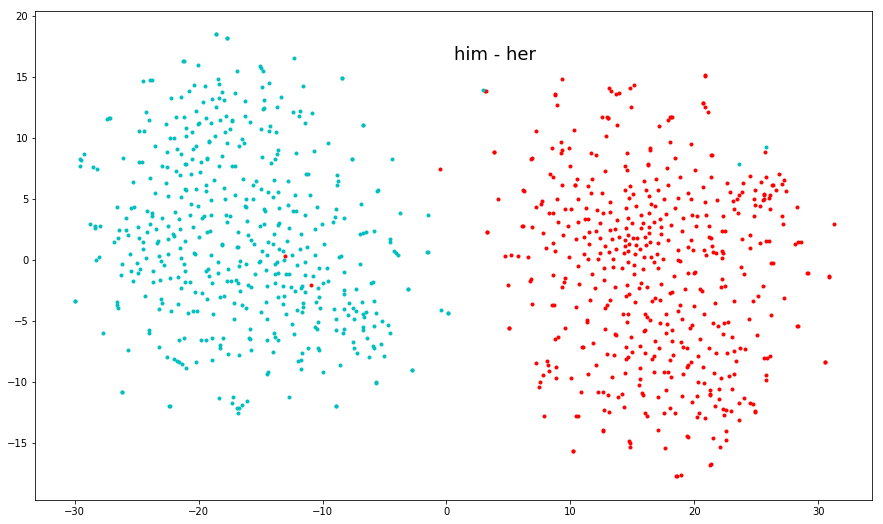

In [48]:
# compute Gender direction for each neutral words 
gender_bias_words = compute_bias_by_projection(model_w2v_AP, limit_vocab, 'him', 'her')

# report overall gender bias score based on compute Gender direction for each neutral words 
m_words, f_words = report_bias(gender_bias_words, 'him', 'her')

# cluster female and male most oriented words and 2D representation
cluster_and_visualize([word[0] for word in m_words], [word[0] for word in f_words], model_w2v_AP, 'him', 'her')


Overall gender bias score for boy-girl: 0.02555811798849523

Top 5 words related to boy
 rank |  word   score
  1.  | malcontented   0.141
  2.  | gangling   0.139
  3.  | jnr   0.132
  4.  | youngster   0.128
  5.  | snr   0.127

Top 5 words related to girl
 rank |  word   score
  1.  | vixen   -0.204
  2.  | frontwoman   -0.200
  3.  | femininity   -0.199
  4.  | chanteuse   -0.196
  5.  | showgirl   -0.196

Gender cluster precision: 0.993


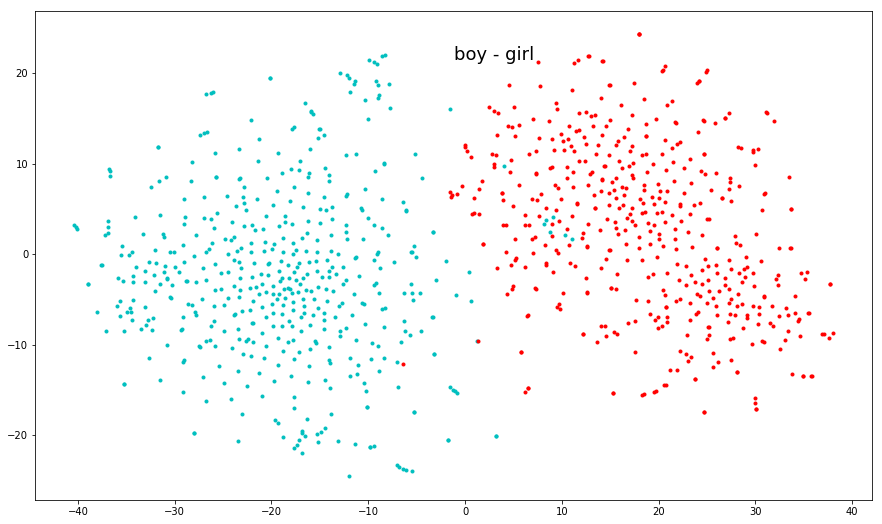

In [49]:
# compute Gender direction for each neutral words 
gender_bias_words = compute_bias_by_projection(model_w2v_AP, limit_vocab, 'boy', 'girl')

# report overall gender bias score based on compute Gender direction for each neutral words 
m_words, f_words = report_bias(gender_bias_words, 'boy', 'girl')

# cluster female and male most oriented words and 2D representation
cluster_and_visualize([word[0] for word in m_words], [word[0] for word in f_words], model_w2v_AP, 'boy', 'girl')


Overall gender bias score for men-women: 0.03588876280149035

Top 5 words related to men
 rank |  word   score
  1.  | accomplices   0.246
  2.  | suspects   0.228
  3.  | codefendants   0.210
  4.  | goatee   0.210
  5.  | surrended   0.210

Top 5 words related to women
 rank |  word   score
  1.  | breastfeeding   -0.247
  2.  | feminist   -0.245
  3.  | women's   -0.230
  4.  | midwifery   -0.230
  5.  | homebirth   -0.219

Gender cluster precision: 0.001


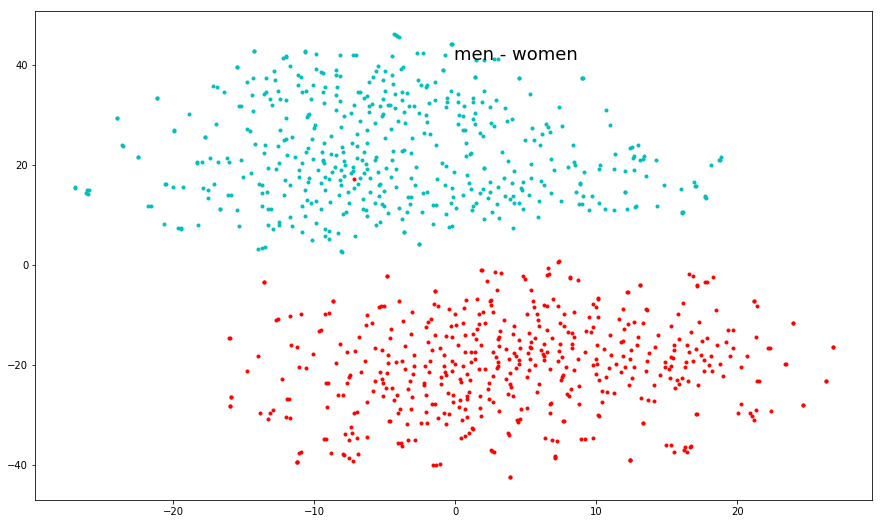

In [50]:
# compute Gender direction for each neutral words 
gender_bias_words = compute_bias_by_projection(model_w2v_AP, limit_vocab, 'men', 'women')

# report overall gender bias score based on compute Gender direction for each neutral words 
m_words, f_words = report_bias(gender_bias_words, 'men', 'women')

# cluster female and male most oriented words and 2D representation
cluster_and_visualize([word[0] for word in m_words], [word[0] for word in f_words], model_w2v_AP, 'men', 'women')

In [ ]:
# compute Gender direction for each neutral words 
gender_bias_words = compute_bias_by_projection(model_w2v_AP, limit_vocab, 'father', 'mother')

# report overall gender bias score based on compute Gender direction for each neutral words 
m_words, f_words = report_bias(gender_bias_words, 'father', 'mother')

# cluster female and male most oriented words and 2D representation
cluster_and_visualize([word[0] for word in m_words], [word[0] for word in f_words], model_w2v_AP, 'father', 'mother')

#    
# EnglishGlove - Compute bias-by-projection

In [18]:
glove_6B = load_glove_embeddings(embedding_eng2_file)
vocab = [word for word in glove_6B if acceptable_word(word, 'english')]

In [19]:
limit_vocab = list(set(vocab) - set(exclude_eng_words))
print('Words accepted in embedding: {}'.format(len(vocab)))
print('Words once removed gender oriented terms: {}'.format(len(limit_vocab)))

Words accepted in embedding: {} 320322
Words once removed gender oriented terms: {} 319961



Overall gender bias score for he-she: 0.05090722898966883

Top 5 words related to he
 rank |  word   score
  1.  | cardinals   0.230
  2.  | nfl   0.226
  3.  | chiefs   0.209
  4.  | parcells   0.201
  5.  | defensive   0.198

Top 5 words related to she
 rank |  word   score
  1.  | okitundu   -0.316
  2.  | schorpen   -0.304
  3.  | meye   -0.303
  4.  | svetlana   -0.300
  5.  | jeria   -0.298

Gender cluster precision: 0.0


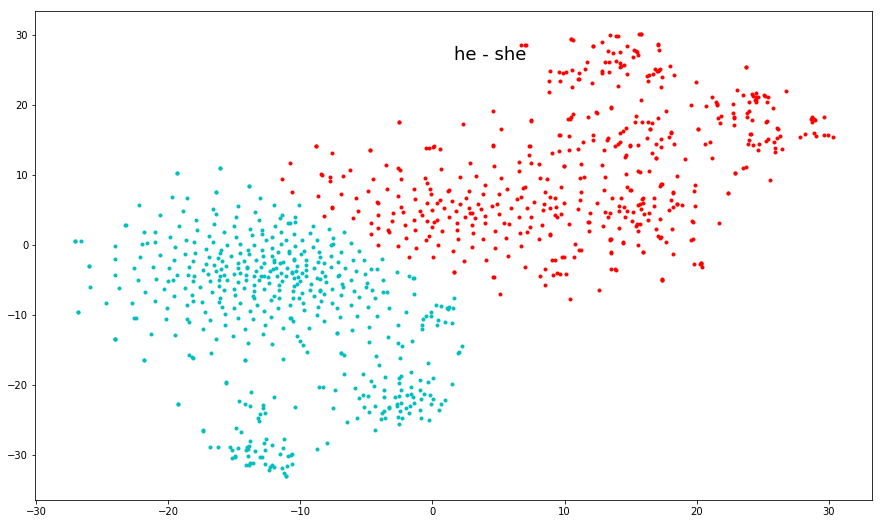

In [21]:
# compute Gender direction for each neutral words 
gender_bias_words = compute_bias_by_projection(glove_6B, limit_vocab, 'he', 'she')

# report overall gender bias score based on compute Gender direction for each neutral words 
m_words, f_words = report_bias(gender_bias_words, 'he', 'she')

# cluster female and male most oriented words and 2D representation
cluster_and_visualize([word[0] for word in m_words], [word[0] for word in f_words], glove_6B, 'he', 'she')

## Gender Neighbours bias words and professions

In [22]:
# Student case 
m, f = get_gender_neigbours_bias('student', glove_6B, gender_bias_words, limit_vocab)
print('Student gender neighbours bias (m/tot) vs word bias: {} vs {}'.format(m/(f+m), gender_bias_words['student']))

Student gender neighbours bias (m/tot) vs word bias: 0.5 vs -0.018596574955796807


In [33]:
list_prof = [prof for prof in eng_professions if prof in limit_vocab]
list_prof = list(set(list_prof) - set(exclude_eng_words))
result_list = gender_neighbours_list_words(list_prof, glove_6B, gender_bias_words, limit_vocab)
write_result(bias_samples_eng, 'occupations_bias_glove.txt', result_list)

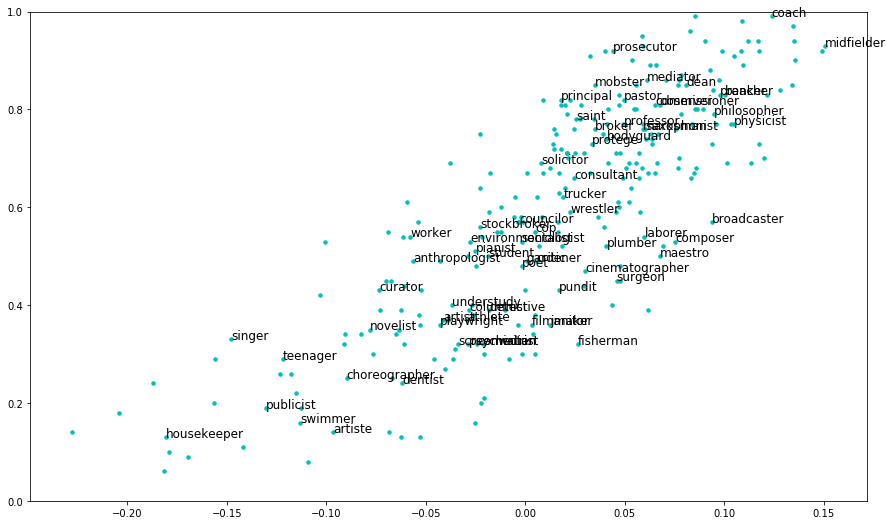

In [34]:
plot_correlation(result_list, list_prof, skip=4)

#    
#    
# Italian hate Speech EVALITA - Compute bias-by-projection

In [ ]:
embeddings_ita1 = get_embedding(embedding_ita1_file)
vocab1 = get_list_words(embeddings_ita1)
limit_vocab1 = list(set(vocab1) - set(exclude_ita_words))
print('Words accepted in embedding: {}'.format(len(vocab1)))
print('Words once removed gender oriented terms: {}'.format(len(limit_vocab1)))

Words accepted in embedding: 280645
Words once removed gender oriented terms: 280488


In [ ]:
word_neutral1, word_pair1 = get_gender_words(limit_vocab1)
print('Single Neutral words: {}'.format(len(word_neutral1)))
print('Pairs of Neutral words: {}'.format(len(word_pair1)))


Overall gender bias score for uomo-donna: 0.02232460277372954

Top 5 words related to uomo
 rank |  word   score
  1.  | chiavatore_or_chiavatrice   0.642
  2.  | bettolino_or_bettolina   0.608
  3.  | genticoglioni_or_genticoglione   0.607
  4.  | finocchio_or_finocchia   0.586
  5.  | lombroso_or_lombrosa   0.573

Top 5 words related to donna
 rank |  word   score
  1.  | infamii_or_infamie   -0.661
  2.  | sgommato_or_sgommata   -0.592
  3.  | otttimo_or_otttima   -0.569
  4.  | pigliavo_or_pigliava   -0.569
  5.  | disgrazio_or_disgrazia   -0.567

Gender cluster precision: 0.441


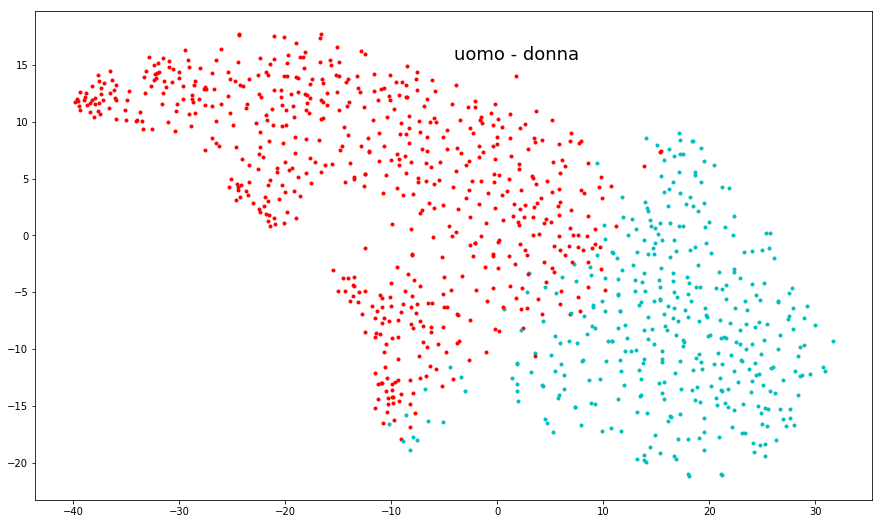

In [37]:
# compute Gender direction for each neutral words 
gender_bias_words1 = compute_bias_ita_by_projection(embeddings_ita1, word_neutral1, word_pair1, 'uomo', 'donna')

# report overall gender bias score based on compute Gender direction for each neutral words 
m_words1, f_words1 = report_bias(gender_bias_words1, 'uomo', 'donna')

# cluster female and male most oriented words and 2D representation
cluster_and_visualize_ita([word[0].split('_')[0] for word in m_words1], 
                          [word[0].split('_')[-1] for word in f_words1], embeddings_ita1, 'uomo', 'donna')


Overall gender bias score for lui-lei: 0.025287161747701598

Top 5 words related to lui
 rank |  word   score
  1.  | spaventapasseri_or_spaventapassere   0.668
  2.  | bettolino_or_bettolina   0.659
  3.  | vergongnio_or_vergongnia   0.652
  4.  | felliniano_or_felliniana   0.645
  5.  | rospo_or_rospa   0.635

Top 5 words related to lei
 rank |  word   score
  1.  | sgommato_or_sgommata   -0.677
  2.  | anfami_or_anfame   -0.640
  3.  | tsi_or_tse   -0.626
  4.  | pigliavo_or_pigliava   -0.617
  5.  | disgrazio_or_disgrazia   -0.612

Gender cluster precision: 0.568


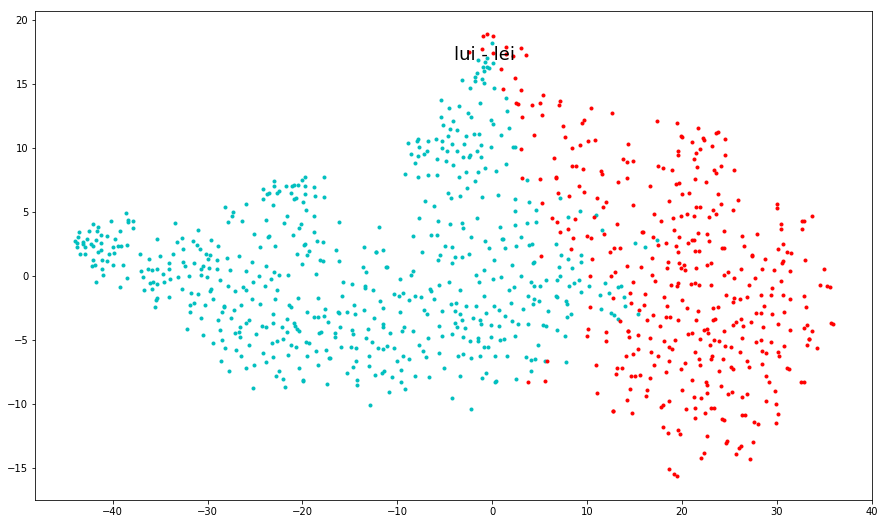

In [38]:
# compute Gender direction for each neutral words 
gender_bias_words1 = compute_bias_ita_by_projection(embeddings_ita1, word_neutral1, word_pair1, 'lui', 'lei')

# report overall gender bias score based on compute Gender direction for each neutral words 
m_words1, f_words1 = report_bias(gender_bias_words1, 'lui', 'lei')

# cluster female and male most oriented words and 2D representation
cluster_and_visualize_ita([word[0].split('_')[0] for word in m_words1], 
                          [word[0].split('_')[-1] for word in f_words1], embeddings_ita1, 'lui', 'lei')


Overall gender bias score for marito-moglie: 0.02581979007652788

Top 5 words related to marito
 rank |  word   score
  1.  | spaventapasseri_or_spaventapassere   0.706
  2.  | elaborato_or_elaborata   0.674
  3.  | bettolino_or_bettolina   0.656
  4.  | genticoglioni_or_genticoglione   0.639
  5.  | felliniano_or_felliniana   0.630

Top 5 words related to moglie
 rank |  word   score
  1.  | pigliavo_or_pigliava   -0.657
  2.  | disgrazio_or_disgrazia   -0.650
  3.  | tramaccioni_or_tramaccione   -0.636
  4.  | tsi_or_tse   -0.624
  5.  | sgommato_or_sgommata   -0.621

Gender cluster precision: 0.459


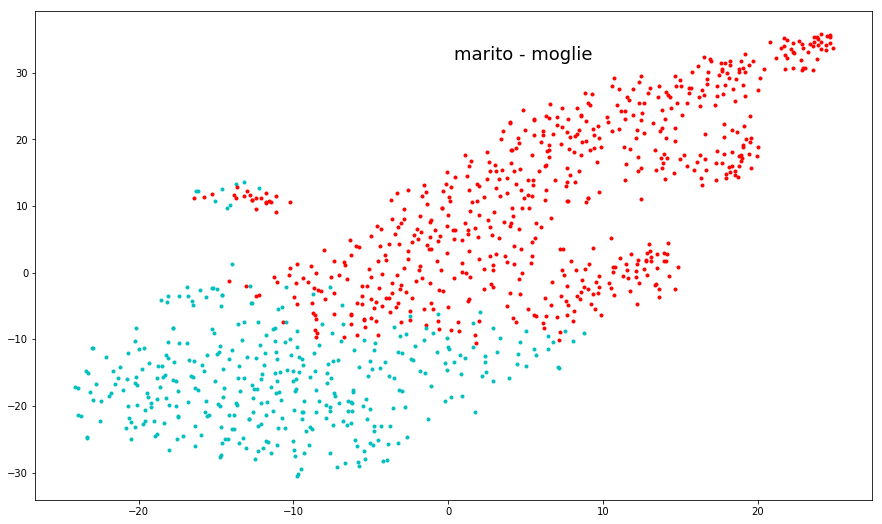

In [39]:
# compute Gender direction for each neutral words 
gender_bias_words1 = compute_bias_ita_by_projection(embeddings_ita1, word_neutral1, word_pair1, 'marito', 'moglie')

# report overall gender bias score based on compute Gender direction for each neutral words 
m_words1, f_words1 = report_bias(gender_bias_words1, 'marito', 'moglie')

# cluster female and male most oriented words and 2D representation
cluster_and_visualize_ita([word[0].split('_')[0] for word in m_words1], 
                          [word[0].split('_')[-1] for word in f_words1], embeddings_ita1, 'marito', 'moglie')


Overall gender bias score for padre-madre: 0.02224732035140778

Top 5 words related to padre
 rank |  word   score
  1.  | rospo_or_rospa   0.667
  2.  | bettolino_or_bettolina   0.665
  3.  | bruciamolo_or_bruciamola   0.597
  4.  | spaventapasseri_or_spaventapassere   0.589
  5.  | elaborato_or_elaborata   0.577

Top 5 words related to madre
 rank |  word   score
  1.  | tramaccioni_or_tramaccione   -0.627
  2.  | carabineri_or_carabinere   -0.601
  3.  | sgommato_or_sgommata   -0.599
  4.  | infamii_or_infamie   -0.588
  5.  | disgrazio_or_disgrazia   -0.583

Gender cluster precision: 0.535


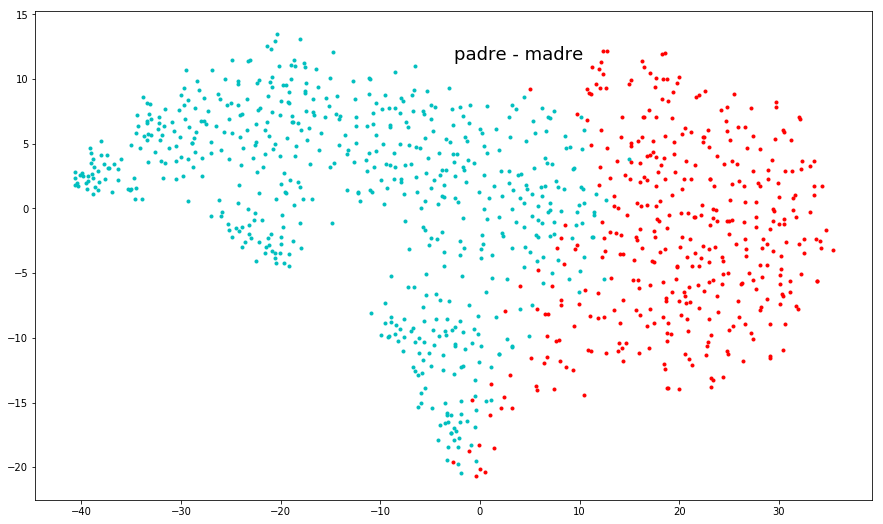

In [40]:
# compute Gender direction for each neutral words 
gender_bias_words1 = compute_bias_ita_by_projection(embeddings_ita1, word_neutral1, word_pair1, 'padre', 'madre')

# report overall gender bias score based on compute Gender direction for each neutral words 
m_words1, f_words1 = report_bias(gender_bias_words1, 'padre', 'madre')

# cluster female and male most oriented words and 2D representation
cluster_and_visualize_ita([word[0].split('_')[0] for word in m_words1], 
                          [word[0].split('_')[-1] for word in f_words1], embeddings_ita1, 'padre', 'madre')


Overall gender bias score for maschio-femmina: 0.06262421882711941

Top 5 words related to maschio
 rank |  word   score
  1.  | chiavatore_or_chiavatrice   0.690
  2.  | bettolino_or_bettolina   0.671
  3.  | afono_or_afona   0.611
  4.  | trano_or_trana   0.585
  5.  | elaborato_or_elaborata   0.585

Top 5 words related to femmina
 rank |  word   score
  1.  | sgommato_or_sgommata   -0.687
  2.  | carabineri_or_carabinere   -0.616
  3.  | pigliavo_or_pigliava   -0.614
  4.  | dobi_or_dobe   -0.599
  5.  | infamii_or_infamie   -0.593

Gender cluster precision: 0.622


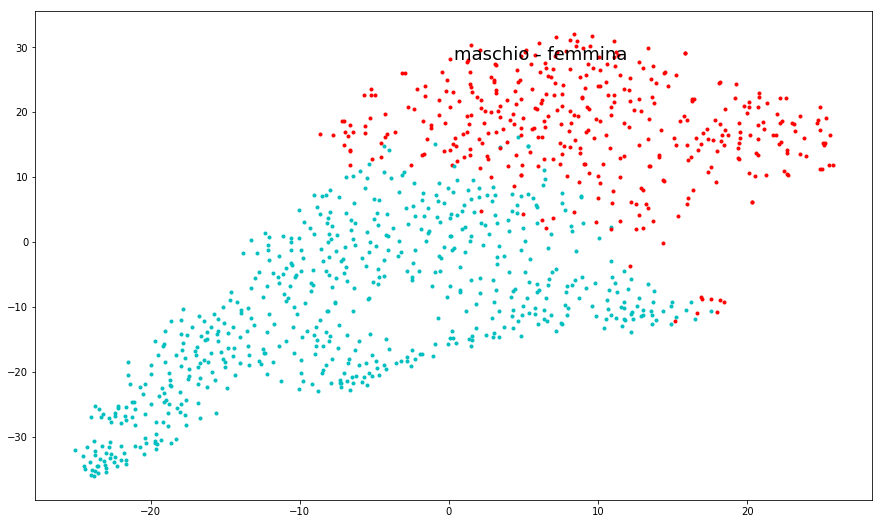

In [41]:
# compute Gender direction for each neutral words 
gender_bias_words1 = compute_bias_ita_by_projection(embeddings_ita1, word_neutral1, word_pair1, 'maschio', 'femmina')

# report overall gender bias score based on compute Gender direction for each neutral words 
m_words1, f_words1 = report_bias(gender_bias_words1, 'maschio', 'femmina')

# cluster female and male most oriented words and 2D representation
cluster_and_visualize_ita([word[0].split('_')[0] for word in m_words1], 
                          [word[0].split('_')[-1] for word in f_words1], embeddings_ita1, 'maschio', 'femmina')


Overall gender bias score for suo-sua: 0.025350423933264938

Top 5 words related to suo
 rank |  word   score
  1.  | felliniano_or_felliniana   0.600
  2.  | trano_or_trana   0.565
  3.  | saviano_or_saviana   0.559
  4.  | bettolino_or_bettolina   0.553
  5.  | elaborato_or_elaborata   0.552

Top 5 words related to sua
 rank |  word   score
  1.  | racio_or_racia   -0.608
  2.  | carabineri_or_carabinere   -0.585
  3.  | pasionario_or_pasionaria   -0.568
  4.  | sgommato_or_sgommata   -0.564
  5.  | cannibalesco_or_cannibalesca   -0.561

Gender cluster precision: 0.526


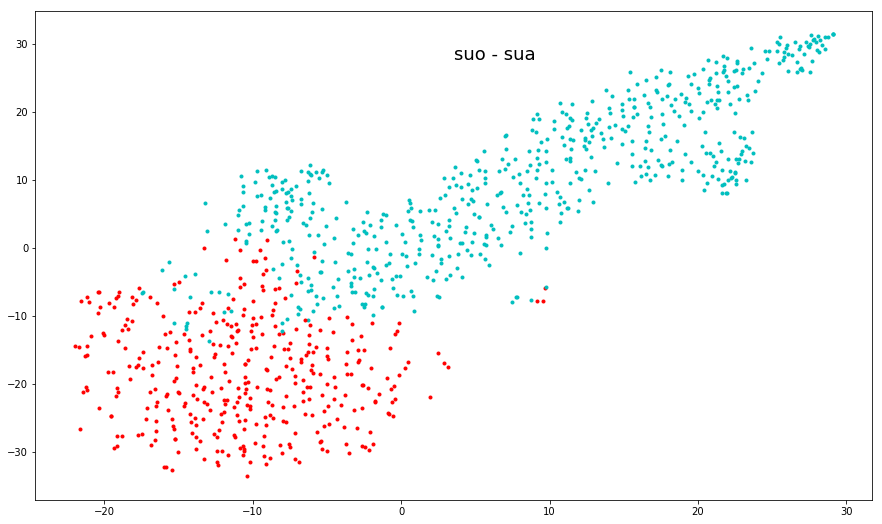

In [42]:
# compute Gender direction for each neutral words 
gender_bias_words1 = compute_bias_ita_by_projection(embeddings_ita1, word_neutral1, word_pair1, 'suo', 'sua')

# report overall gender bias score based on compute Gender direction for each neutral words 
m_words1, f_words1 = report_bias(gender_bias_words1, 'suo', 'sua')

# cluster female and male most oriented words and 2D representation
cluster_and_visualize_ita([word[0].split('_')[0] for word in m_words1], 
                          [word[0].split('_')[-1] for word in f_words1], embeddings_ita1, 'suo', 'sua')

#   
# Italian Generic EVALITA - Compute bias-by-projection

In [11]:
embeddings_ita2 = get_embedding_sqlite(embedding_ita2_file)
vocab2 = [word for word in embeddings_ita2 if acceptable_word(word, 'italian')]
limit_vocab2 = list(set(vocab2) - set(exclude_ita_words))
print('Words accepted in embedding: {}'.format(len(vocab2)))
print('Words once removed gender oriented terms: {}'.format(len(limit_vocab2)))

Words accepted in embedding: 534119
Words once removed gender oriented terms: 533951


In [12]:
word_neutral2, word_pair2 = get_gender_words(limit_vocab2)
print('Single Neutral words: {}'.format(len(word_neutral2)))
print('Pairs of Neutral words: {}'.format(len(word_pair2)))

Single Neutral words: 379264
Pairs of Neutral words: 77700



Overall gender bias score for uomo-donna: 0.06968809347249597

Top 5 words related to uomo
 rank |  word   score
  1.  | individuo_or_individua   0.917
  2.  | intelletto_or_intelletta   0.677
  3.  | destino_or_destina   0.625
  4.  | abisso_or_abissa   0.614
  5.  | personaggio_or_personaggia   0.608

Top 5 words related to donna
 rank |  word   score
  1.  | artisto_or_artista   -0.724
  2.  | angoscio_or_angoscia   -0.568
  3.  | adolescenti_or_adolescente   -0.555
  4.  | osti_or_oste   -0.541
  5.  | arcieri_or_arciere   -0.538

Gender cluster precision: 0.74


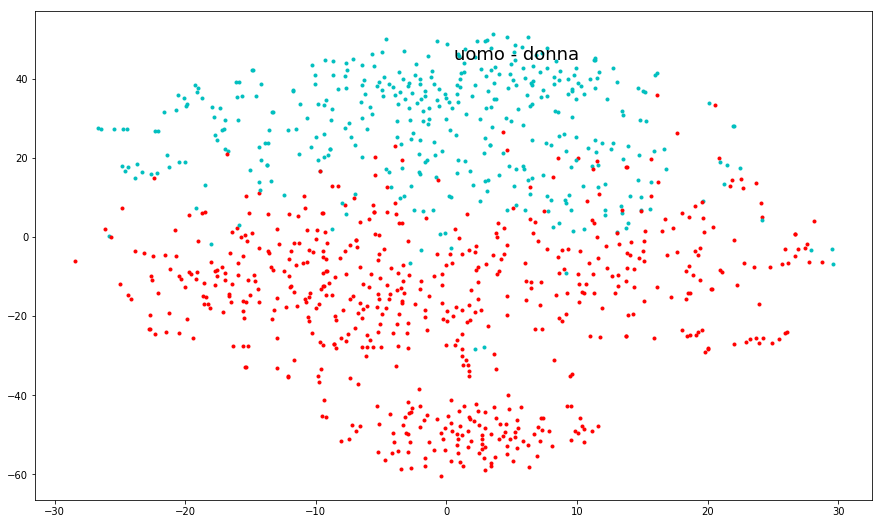

In [13]:
# compute Gender direction for each neutral words 
gender_bias_words2 = compute_bias_ita_by_projection(embeddings_ita2, word_neutral2, word_pair2, 'uomo', 'donna')

# report overall gender bias score based on compute Gender direction for each neutral words 
m_words2, f_words2 = report_bias(gender_bias_words2, 'uomo', 'donna')

# cluster female and male most oriented words and 2D representation
cluster_and_visualize_ita([word[0].split('_')[0] for word in m_words2], 
                          [word[0].split('_')[-1] for word in f_words2], embeddings_ita2, 'uomo', 'donna')


Overall gender bias score for lui-lei: 0.04543859737219356

Top 5 words related to lui
 rank |  word   score
  1.  | destino_or_destina   0.772
  2.  | individuo_or_individua   0.741
  3.  | me_or_messa   0.727
  4.  | egli_or_egle   0.656
  5.  | genero_or_genera   0.604

Top 5 words related to lei
 rank |  word   score
  1.  | beni_or_bene   -0.705
  2.  | fortuno_or_fortuna   -0.653
  3.  | qualcoso_or_qualcosa   -0.651
  4.  | neppuri_or_neppure   -0.580
  5.  | trasporti_or_trasporte   -0.554

Gender cluster precision: 0.423


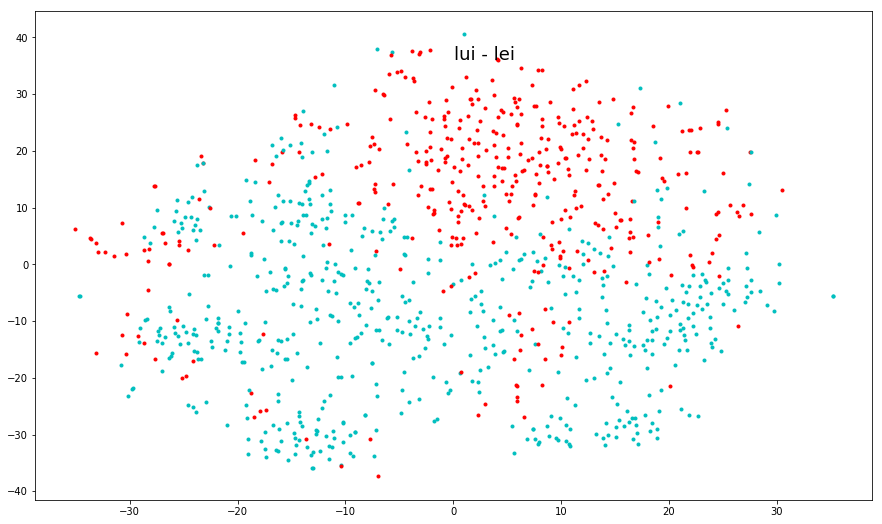

In [14]:
# compute Gender direction for each neutral words 
gender_bias_words2 = compute_bias_ita_by_projection(embeddings_ita2, word_neutral2, word_pair2, 'lui', 'lei')

# report overall gender bias score based on compute Gender direction for each neutral words 
m_words2, f_words2 = report_bias(gender_bias_words2, 'lui', 'lei')

# cluster female and male most oriented words and 2D representation
cluster_and_visualize_ita([word[0].split('_')[0] for word in m_words2], 
                          [word[0].split('_')[-1] for word in f_words2], embeddings_ita2, 'lui', 'lei')


Overall gender bias score for marito-moglie: 0.052964202947824626

Top 5 words related to marito
 rank |  word   score
  1.  | genero_or_genera   0.896
  2.  | destino_or_destina   0.672
  3.  | coniugo_or_coniuga   0.649
  4.  | idolo_or_idola   0.642
  5.  | individuo_or_individua   0.596

Top 5 words related to moglie
 rank |  word   score
  1.  | generale_or_generalessa   -0.628
  2.  | nuoro_or_nuora   -0.600
  3.  | quindicenni_or_quindicenne   -0.593
  4.  | pigiamo_or_pigiama   -0.586
  5.  | mentori_or_mentore   -0.585

Gender cluster precision: 0.392


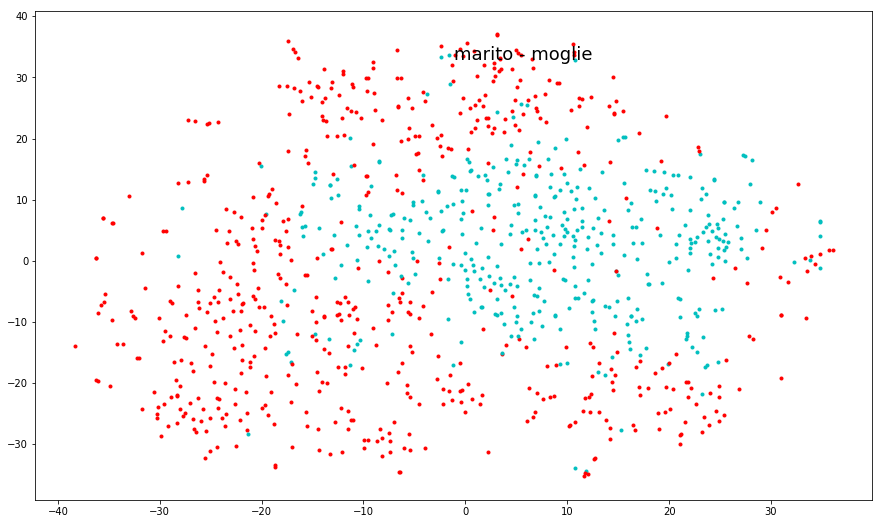

In [15]:
# compute Gender direction for each neutral words 
gender_bias_words2 = compute_bias_ita_by_projection(embeddings_ita2, word_neutral2, word_pair2, 'marito', 'moglie')

# report overall gender bias score based on compute Gender direction for each neutral words 
m_words2, f_words2 = report_bias(gender_bias_words2, 'marito', 'moglie')

# cluster female and male most oriented words and 2D representation
cluster_and_visualize_ita([word[0].split('_')[0] for word in m_words2], 
                          [word[0].split('_')[-1] for word in f_words2], embeddings_ita2, 'marito', 'moglie')


Overall gender bias score for maschio-femmina: 0.05263086774542728

Top 5 words related to maschio
 rank |  word   score
  1.  | individuo_or_individua   0.599
  2.  | drago_or_draga   0.576
  3.  | bozzo_or_bozza   0.564
  4.  | bufalo_or_bufala   0.558
  5.  | medicai_or_medicae   0.552

Top 5 words related to femmina
 rank |  word   score
  1.  | longissimo_or_longissima   -0.603
  2.  | bui_or_bue   -0.566
  3.  | mattono_or_mattona   -0.531
  4.  | fanfaroni_or_fanfarone   -0.528
  5.  | giovi_or_giove   -0.524

Gender cluster precision: 0.565


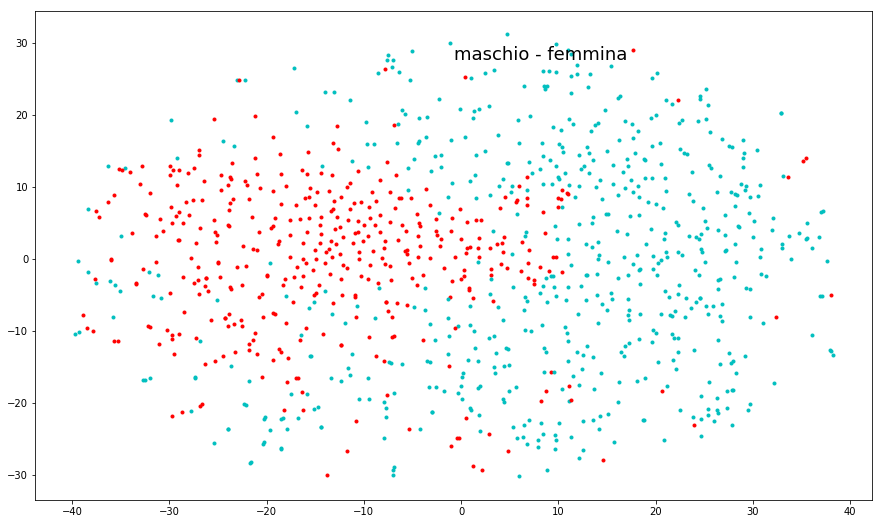

In [16]:
# compute Gender direction for each neutral words 
gender_bias_words2 = compute_bias_ita_by_projection(embeddings_ita2, word_neutral2, word_pair2, 'maschio', 'femmina')

# report overall gender bias score based on compute Gender direction for each neutral words 
m_words2, f_words2 = report_bias(gender_bias_words2, 'maschio', 'femmina')

# cluster female and male most oriented words and 2D representation
cluster_and_visualize_ita([word[0].split('_')[0] for word in m_words2], 
                          [word[0].split('_')[-1] for word in f_words2], embeddings_ita2, 'maschio', 'femmina')


Overall gender bias score for suo-sua: 0.06980301661721025

Top 5 words related to suo
 rank |  word   score
  1.  | settantasettesimo_or_settantasettesima   0.565
  2.  | finanziaro_or_finanziara   0.555
  3.  | pioneristico_or_pioneristica   0.532
  4.  | egli_or_egle   0.527
  5.  | furfantesco_or_furfantesca   0.524

Top 5 words related to sua
 rank |  word   score
  1.  | meditanti_or_meditante   -0.612
  2.  | subcontraenti_or_subcontraente   -0.604
  3.  | trotterellanti_or_trotterellante   -0.596
  4.  | mercuriali_or_mercuriale   -0.585
  5.  | boxari_or_boxare   -0.575

Gender cluster precision: 0.69


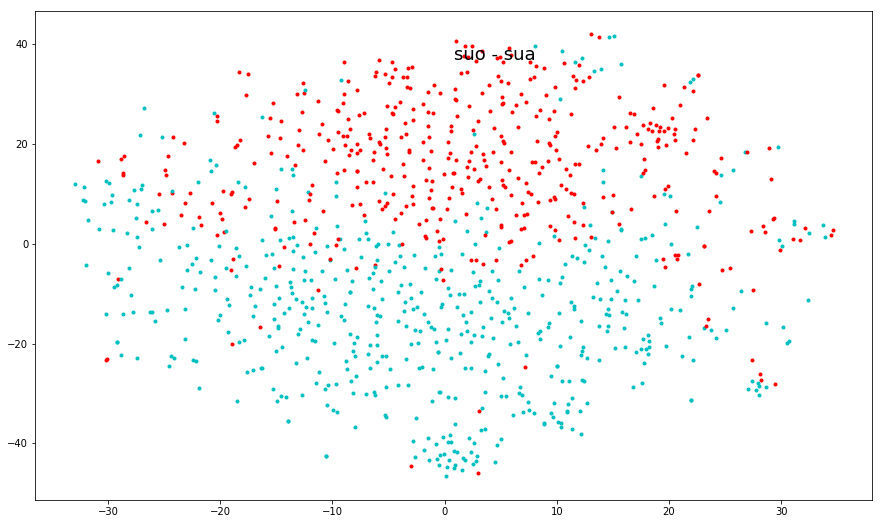

In [17]:
# compute Gender direction for each neutral words 
gender_bias_words2 = compute_bias_ita_by_projection(embeddings_ita2, word_neutral2, word_pair2, 'suo', 'sua')

# report overall gender bias score based on compute Gender direction for each neutral words 
m_words2, f_words2 = report_bias(gender_bias_words2, 'suo', 'sua')

# cluster female and male most oriented words and 2D representation
cluster_and_visualize_ita([word[0].split('_')[0] for word in m_words2], 
                          [word[0].split('_')[-1] for word in f_words2], embeddings_ita2, 'suo', 'sua')

#    
# Italian word2vec embedding - Compute bias-by-projection

In [11]:
embeddings_ita3 = get_embedding2(embedding_ita3_file)
vocab3 = get_list_words(model_w2v_ita)
limit_vocab3 = list(set(vocab3) - set(exclude_ita_words))
print('Words accepted in embedding: {}'.format(len(vocab3)))
print('Words once removed gender oriented terms: {}'.format(len(limit_vocab3)))

Words accepted in embedding: 455159
Words once removed gender oriented terms: 454994


In [12]:
word_neutral3, word_pair3 = get_gender_words(limit_vocab3)
print('Single Neutral words: {}'.format(len(word_neutral3)))
print('Pairs of Neutral words: {}'.format(len(word_pair3)))

Single Neutral words: 364534
Pairs of Neutral words: 45428



Overall gender bias score for uomo-donna: 0.04061475579356604

Top 5 words related to uomo
 rank |  word   score
  1.  | armeo_or_armea   0.532
  2.  | firo_or_fira   0.527
  3.  | sko_or_ska   0.524
  4.  | soletto_or_soletta   0.509
  5.  | villotto_or_villotta   0.480

Top 5 words related to donna
 rank |  word   score
  1.  | circuito_or_circuita   -0.500
  2.  | pachino_or_pachina   -0.486
  3.  | pamphili_or_pamphile   -0.459
  4.  | lagni_or_lagne   -0.454
  5.  | quatro_or_quatra   -0.448

Gender cluster precision: 0.454


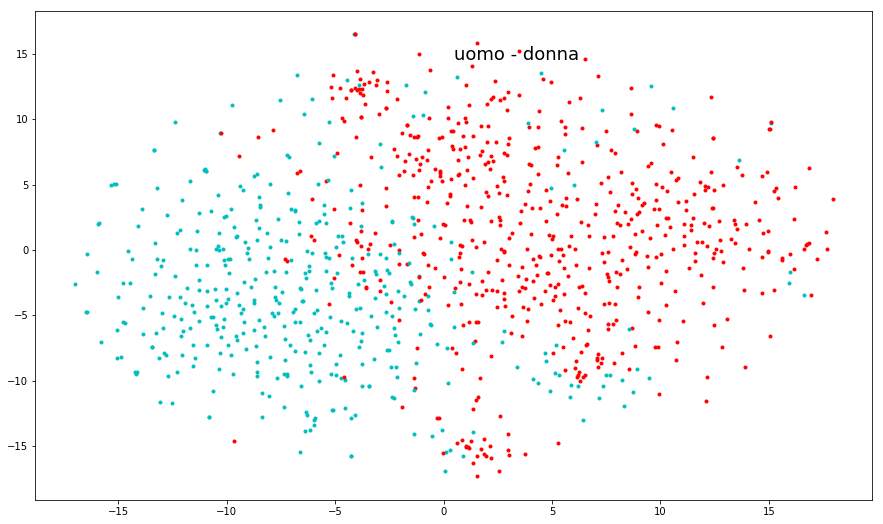

In [15]:
# compute Gender direction for each neutral words 
gender_bias_words3 = compute_bias_ita_by_projection(embeddings_ita3, word_neutral3, word_pair3, 'uomo', 'donna')

# report overall gender bias score based on compute Gender direction for each neutral words 
m_words3, f_words3 = report_bias(gender_bias_words3, 'uomo', 'donna')

# cluster female and male most oriented words and 2D representation
cluster_and_visualize_ita([word[0].split('_')[0] for word in m_words3], 
                          [word[0].split('_')[-1] for word in f_words3], embeddings_ita3, 'uomo', 'donna')


Overall gender bias score for lui-lei: 0.043450603543698

Top 5 words related to lui
 rank |  word   score
  1.  | bellario_or_bellaria   0.573
  2.  | raganelli_or_raganelle   0.563
  3.  | tradi_or_trade   0.560
  4.  | firo_or_fira   0.548
  5.  | armeo_or_armea   0.542

Top 5 words related to lei
 rank |  word   score
  1.  | pachino_or_pachina   -0.556
  2.  | deputate_or_deputatessa   -0.533
  3.  | fari_or_fare   -0.519
  4.  | marelli_or_marelle   -0.505
  5.  | agostini_or_agostine   -0.501

Gender cluster precision: 0.538


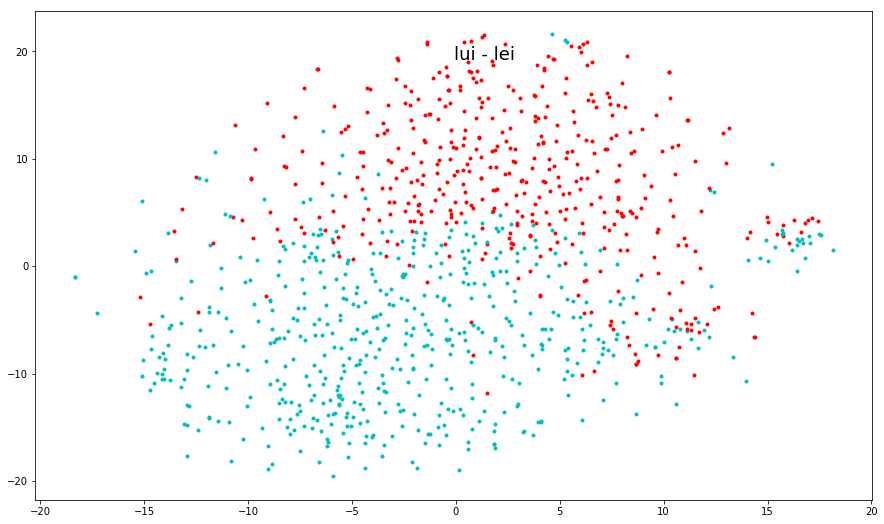

In [16]:
# compute Gender direction for each neutral words 
gender_bias_words3 = compute_bias_ita_by_projection(embeddings_ita3, word_neutral3, word_pair3, 'lui', 'lei')

# report overall gender bias score based on compute Gender direction for each neutral words 
m_words3, f_words3 = report_bias(gender_bias_words3, 'lui', 'lei')

# cluster female and male most oriented words and 2D representation
cluster_and_visualize_ita([word[0].split('_')[0] for word in m_words3], 
                          [word[0].split('_')[-1] for word in f_words3], embeddings_ita3, 'lui', 'lei')


Overall gender bias score for marito-moglie: 0.02723274749254897

Top 5 words related to marito
 rank |  word   score
  1.  | nepo_or_nepa   0.506
  2.  | raganelli_or_raganelle   0.505
  3.  | bellario_or_bellaria   0.472
  4.  | loppi_or_loppe   0.468
  5.  | genero_or_genera   0.467

Top 5 words related to moglie
 rank |  word   score
  1.  | nuoro_or_nuora   -0.611
  2.  | marelli_or_marelle   -0.526
  3.  | ello_or_ella   -0.495
  4.  | eloro_or_elora   -0.470
  5.  | diedri_or_diedre   -0.468

Gender cluster precision: 0.482


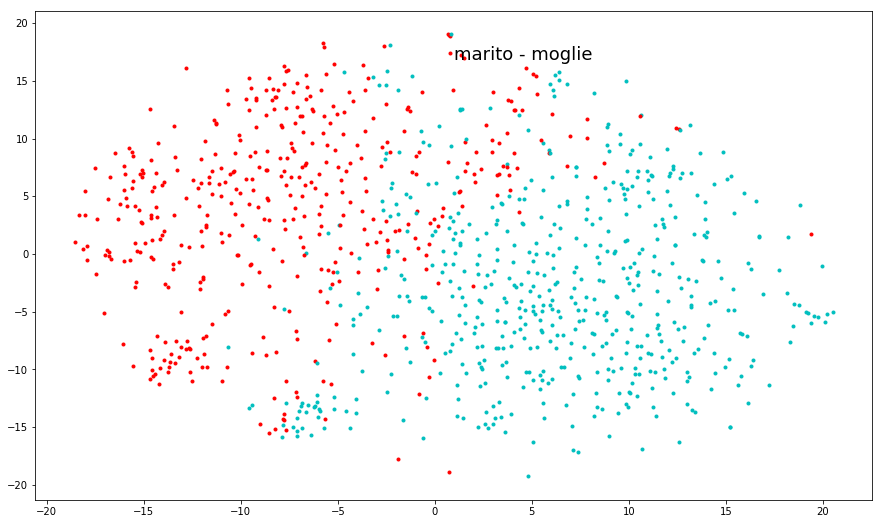

In [17]:
# compute Gender direction for each neutral words 
gender_bias_words3 = compute_bias_ita_by_projection(embeddings_ita3, word_neutral3, word_pair3, 'marito', 'moglie')

# report overall gender bias score based on compute Gender direction for each neutral words 
m_words3, f_words3 = report_bias(gender_bias_words3, 'marito', 'moglie')

# cluster female and male most oriented words and 2D representation
cluster_and_visualize_ita([word[0].split('_')[0] for word in m_words3], 
                          [word[0].split('_')[-1] for word in f_words3], embeddings_ita3, 'marito', 'moglie')


Overall gender bias score for maschio-femmina: 0.027081535243400668

Top 5 words related to maschio
 rank |  word   score
  1.  | parto_or_parta   0.357
  2.  | nido_or_nida   0.355
  3.  | teuto_or_teuta   0.343
  4.  | sessi_or_sesse   0.340
  5.  | jasmini_or_jasmine   0.330

Top 5 words related to femmina
 rank |  word   score
  1.  | incubo_or_incuba   -0.427
  2.  | covo_or_cova   -0.385
  3.  | rettori_or_rettrici   -0.384
  4.  | artemio_or_artemia   -0.375
  5.  | bassano_or_bassana   -0.373

Gender cluster precision: 0.479


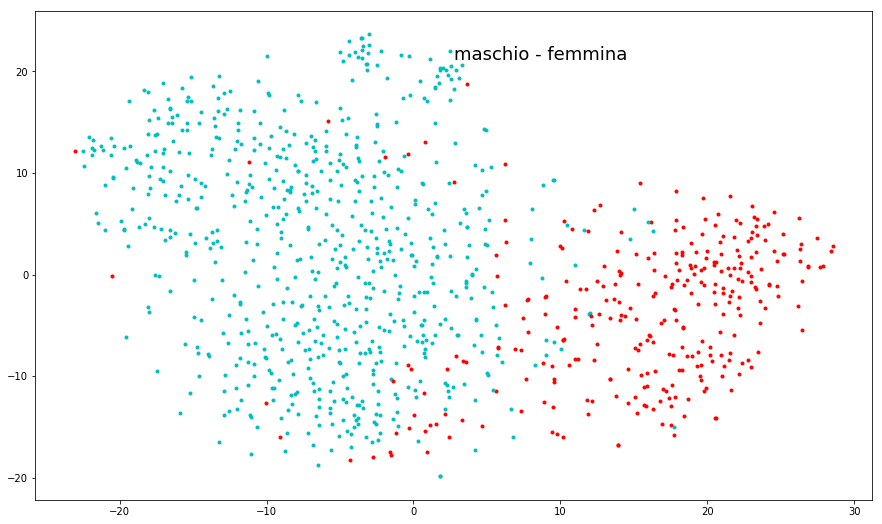

In [18]:
# compute Gender direction for each neutral words 
gender_bias_words3 = compute_bias_ita_by_projection(embeddings_ita3, word_neutral3, word_pair3, 'maschio', 'femmina')

# report overall gender bias score based on compute Gender direction for each neutral words 
m_words3, f_words3 = report_bias(gender_bias_words3, 'maschio', 'femmina')

# cluster female and male most oriented words and 2D representation
cluster_and_visualize_ita([word[0].split('_')[0] for word in m_words3], 
                          [word[0].split('_')[-1] for word in f_words3], embeddings_ita3, 'maschio', 'femmina')


Overall gender bias score for suo-sua: 0.034042004167693124

Top 5 words related to suo
 rank |  word   score
  1.  | phylo_or_phyla   0.441
  2.  | che_or_chessa   0.431
  3.  | raganelli_or_raganelle   0.428
  4.  | cui_or_cue   0.427
  5.  | tradi_or_trade   0.423

Top 5 words related to sua
 rank |  word   score
  1.  | diedri_or_diedre   -0.498
  2.  | temperamenti_or_temperamente   -0.453
  3.  | epigoni_or_epigone   -0.436
  4.  | scapi_or_scape   -0.430
  5.  | pennacchio_or_pennacchia   -0.410

Gender cluster precision: 0.448


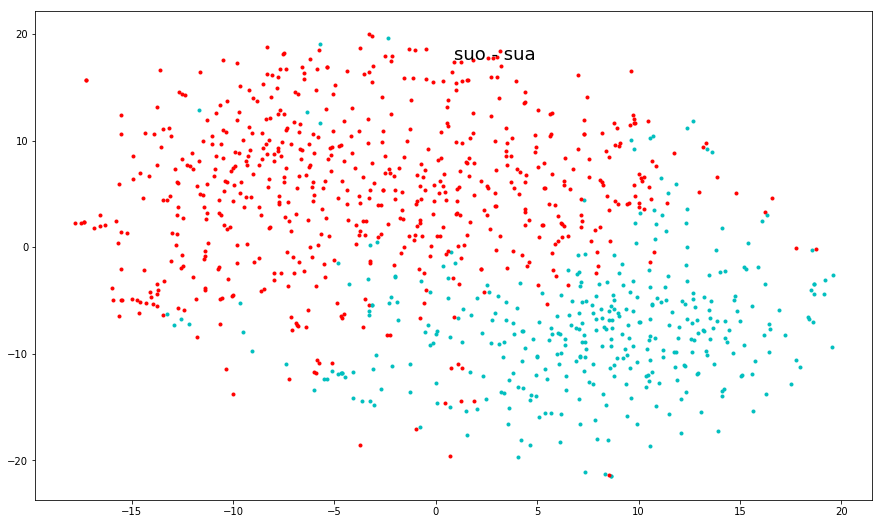

In [19]:
# compute Gender direction for each neutral words 
gender_bias_words3 = compute_bias_ita_by_projection(embeddings_ita3, word_neutral3, word_pair3, 'suo', 'sua')

# report overall gender bias score based on compute Gender direction for each neutral words 
m_words3, f_words3 = report_bias(gender_bias_words3, 'suo', 'sua')

# cluster female and male most oriented words and 2D representation
cluster_and_visualize_ita([word[0].split('_')[0] for word in m_words3], 
                          [word[0].split('_')[-1] for word in f_words3], embeddings_ita3, 'suo', 'sua')